In [1]:
import json
import math
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import nvdiffrast.torch as dr
import torch
from torch import Tensor
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
from rich.console import Console
from rich.tree import Tree

from extension import ops_3d, Mesh, utils
from segmentation.networks.SemanticSAM import SemanticSAM, semantic_sam_l
from segmentation.tree_segmentation import TreeStructure, TreeData, MaskData, Tree3Dv2, Tree3D, TreePredictor, \
    TreeSegmentMetric
from segmentation.tree_segmentation.util import show_masks

2023-07-23 14:12:05.424504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 14:12:06.453219: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-07-23 14:12:06.453344: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

2.0.1+cu117


In [3]:
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
glctx = dr.RasterizeCudaContext()
cache_root = Path('~/wan_code/segmentation/tree_segmentation/results').expanduser()

In [4]:
data_root = Path('/data4/S3DIS/2D_3D_S/area_1').expanduser()
print(f"Data Root: {data_root}")
mesh_path = data_root.joinpath('3d/rgb.obj')
image_dir = data_root.joinpath('data/rgb')
depth_dir = data_root.joinpath('data/depth')
seg_label_dir = data_root.joinpath("data/semantic")
pose_dir = data_root.joinpath('data/pose')
# print(list(os.scandir(data_root)))
# shapes = list(os.scandir(data_root))
image_names = sorted([image_path.stem for image_path in image_dir.glob("*.png")])
print(f'There are {len(image_names)} images')

Data Root: /data4/S3DIS/2D_3D_S/area_1
There are 10327 images


In [5]:
mesh = Mesh.load(mesh_path)  #.to(device)
print(mesh)
# mesh = mesh.to(device=device)

Mesh(vertices=193957, faces=157898, tex, nrm, mat=['bsdf', 'kd', 'ka', 'name', 'ks'])


In [23]:
for attr in ['v_pos', 'f_pos', 'v_tex', 'f_tex', 'v_nrm', 'f_nrm']:
    if getattr(mesh, attr) is not None:
        setattr(mesh, attr, getattr(mesh, attr).to(device))
print(mesh.AABB)

tensor([[-23.6552,  -2.3947, -53.1942],
        [  2.3214,   7.9878,   2.2254]], device='cuda:0')


examle name: camera_14c620a723e54e8cb6847b4a0c532dca_office_1_frame_51_domain_rgb
image: numpy((1080, 1080, 3), uint8)


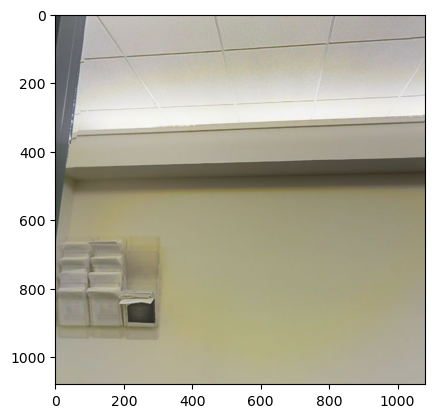

In [25]:
example = random.choice(image_names)
print('examle name:', example)
image = utils.load_image(image_dir.joinpath(example + '.png'))
print('image:', utils.show_shape(image))
plt.imshow(image)
plt.show()

In [26]:
with pose_dir.joinpath(f"{example[:-4]}_pose.json").open('r') as f:
    camera_info = json.load(f)  # type: dict
print(list(camera_info.keys()))
for k, v in camera_info.items():
    print(k, v, sep=': ')

['camera_k_matrix', 'field_of_view_rads', 'camera_uuid', 'rotation_from_original_to_point', 'point_uuid', 'camera_location', 'frame_num', 'camera_rt_matrix', 'final_camera_rotation', 'camera_original_rotation', 'room']
camera_k_matrix: [[950.623291015625, 0.0, 540.0], [0.0, 950.623291015625, 540.0], [0.0, 0.0, 1.0]]
field_of_view_rads: 1.033188439417842
camera_uuid: 14c620a723e54e8cb6847b4a0c532dca
rotation_from_original_to_point: [-0.21829751133918762, -0.029872817918658257, 1.6003327369689941]
point_uuid: 14c620a723e54e8cb6847b4a0c532dca
camera_location: [-15.812224, 34.591507, 1.521615]
frame_num: 51
camera_rt_matrix: [[0.12358316779136658, -0.9923325777053833, 0.0018129311501979828, 36.277645111083984], [0.2189146727323532, 0.025481190532445908, -0.9754112362861633, 4.064295291900635], [0.9678861498832703, 0.12094128876924515, 0.22038520872592926, 10.785550117492676]]
final_camera_rotation: [1.7930060625076294, -0.0018129321979358792, -1.4468961954116821]
camera_original_rotation: 

tensor([[ 1.7604,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -1.7604,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -1.0002, -0.2000],
        [ 0.0000,  0.0000, -1.0000,  0.0000]], device='cuda:0')
tensor([[     0.1236,     -0.9923,      0.0018,     36.2776],
        [     0.2189,      0.0255,     -0.9754,      4.0643],
        [     0.9679,      0.1209,      0.2204,     10.7856],
        [     0.0000,      0.0000,      0.0000,      1.0000]], device='cuda:0')
view pos: F32Tensor[3] tensor([    0.0000,     0.0000,     0.0000], device='cuda:0')
view dir: tensor([-0.4154,  0.9088,  0.0400], device='cuda:0')
output image: F32Tensor[1, 1080, 1080, 3] tensor(0.5000, device='cuda:0') tensor(0.5000, device='cuda:0')


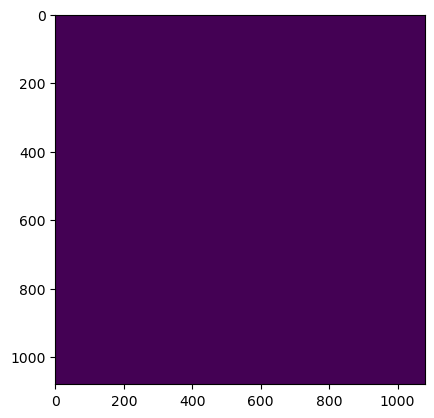

In [28]:
utils.set_printoptions()
image_size = 1080
fovy = camera_info['field_of_view_rads']
Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size), device=device)
Tv2s = torch.tensor(camera_info['camera_k_matrix'], device=device, dtype=torch.float)
# Tv2s2 = ops_3d.camera_intrinsics(fovy=torch.tensor(fovy), size=[image_size, image_size], opengl=False)
print(Tv2c)
# print(Tv2s, Tv2s2)
Tw2v = torch.tensor(camera_info['camera_rt_matrix'], device=device, dtype=torch.float)
Tw2v = ops_3d.to_4x4(Tw2v)
print(Tw2v)
# print('Tv2w:', torch.inverse(Tw2v))
Tw2c = Tv2c @ Tw2v
v_pos = ops_3d.xfm(mesh.v_pos[None], Tw2c)
# assert v_pos.ndim == 3
rast, _ = dr.rasterize(glctx, v_pos, mesh.f_pos.int(), (image_size, image_size))
view_pos = torch.tensor(camera_info['camera_location'], device=device)
print('view pos:', utils.show_shape(view_pos), view_pos - torch.inverse(Tw2v)[:3, 3])
# nrm = ops_3d.compute_shading_normal(mesh,view_pos, rast, None)
nrm = ops_3d.compute_shading_normal_face(mesh, view_pos[None, None, None], rast)
view_dir = ops_3d.normalize(view_pos)
print('view dir:', view_dir)
light = ops_3d.normalize(view_dir + torch.randn(3, device=device) * 0.01)
img = ops_3d.Blinn_Phong(
    nrm, light, view_dir, (nrm.new_full((3,), 0.5), nrm.new_full((3,), 0.5), nrm.new_full((3,), 0.1))
).clamp(0, 1)
img = dr.antialias(img, rast, v_pos, mesh.f_pos.int())
print('output image:', utils.show_shape(img), *img.aminmax())
plt.imshow((rast[:, :, :, -1] > 0).cpu().numpy()[0])
plt.show()